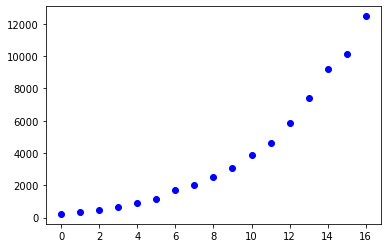

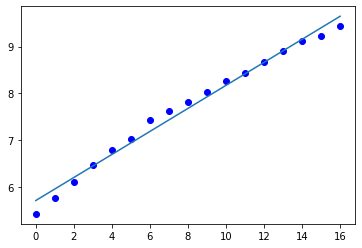

R0 in italia è circa 3.4546218944855953


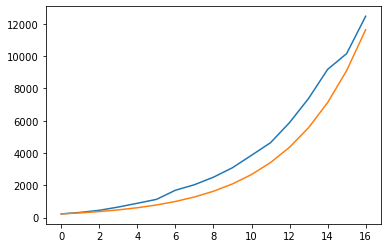

In [1]:
import pandas as pd
import datetime
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LinearRegression
#import seaborn
from scipy.integrate import odeint 
import sympy as sm



#RICAVIAMO R0 E DI CONSEGUENZA BETA DAI DATI DEL COVID IN ITALIA UTILIZZANDO IL MODELLO SIR



#importiamo un dataset da cui estrarre i dati dei contagi nel mondo e in particolare in italia 
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df=pd.read_csv(url, error_bad_lines=False)
df=df.rename(columns={"Province/Sate":"province", "Country/Region":"country"})

italia=df.loc[df.country=="Italy"]
italia=italia.loc[:,"1/22/20": ]
contagi_italia=italia.iloc[0].tolist()



#eliminiamo i primi dati dei contagiati che potevano essere casi isolati/importati e anche i dati dopo che sono iniziate le misure di quarantena per calcolare R0
I=[]
for i in range(50):
	if contagi_italia[i] >200:
		I.append(contagi_italia[i])
#print(I)


#disegnamo il grafico dei contagi (giorni, contagiati)
giorni=[]
for i in range(len(I)):
	giorni.append(i)
plt.plot(giorni,I, 'bo')
plt.show()

#troviamo il valore R0 del modello SIR

#trasformiamo in scala logaritmica
I0=min(I)
logI=[]
for i in range(len(I)):
	logI.append(math.log(I[i]))
#print(logI)

plt.plot(giorni, logI, 'bo')


#usiamo il metodo della regressione lineare per trovare una retta che approssima i punti sulla scala logaritmica
x = np.array(giorni).reshape((-1, 1))
y = np.array(logI)
model=LinearRegression()
model.fit(x,y)

b=model.coef_
c=model.intercept_
#print(model.coef_)

pred_y=model.predict(x)
plt.plot(giorni,pred_y)
plt.show()

#quindi abbiamo approssimato logI con b*x+c. Consideriamo duqnue b=a(R0-1) e cioè R0=b*(1/a)+1.
R0=b*10+1
R0=R0[0]
print('R0 in italia è circa ' +str(R0))

#facciamo un controllo dei grafici in scala non logaritmica
plt.plot(giorni,I)
plt.plot(giorni, I0*np.exp(b*giorni))
plt.show()

#condizioni iniziali in italia

Sani=70000000
Infetti=100
Asintomatici=200

initial_population=Sani+Asintomatici
mean_infective_period=10
beta_zero=R0*0.1/(initial_population)
#print(beta_zero)






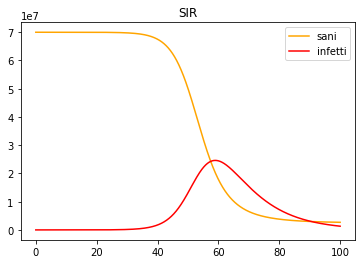

No handles with labels found to put in legend.


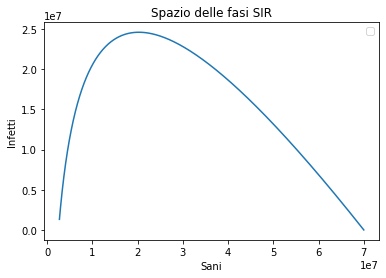

In [2]:
#SIR

def SIR_model(y,t,beta,alpha):
	S,I =y
	dSdt=-beta*S*I
	dIdt=beta*S*I-alpha*I

	return ([dSdt , dIdt])


def SIR(S0,I0,beta):

	#parameters
	t = np.linspace(0,100, 10000)
	alpha1=0.1   #rate at which people leave the class I (by recovering)
	

	#solve the problem
	solution=odeint(SIR_model, [S0,I0],t, args=(beta,alpha1))
	solution=np.array(solution)

	N0=S0+I0  
	#recovered=N0-solution[:,0]-solution[:,1]


	plt.plot(t,solution[:,0], color="orange",label="sani")    #sani
	plt.plot(t,solution[:,1], color="red", label="infetti")     #infetti
	#plt.plot(t,recovered)
	plt.title("SIR")
	plt.legend()
	plt.show()

	plt.plot(solution[:,0],solution[:,1])
	plt.xlabel("Sani")
	plt.ylabel("Infetti")
	plt.title("Spazio delle fasi SIR")
	plt.legend()
	plt.show()



sir=SIR(Sani,100,beta_zero)







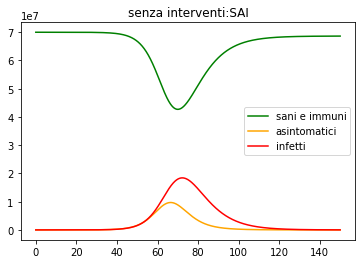

No handles with labels found to put in legend.


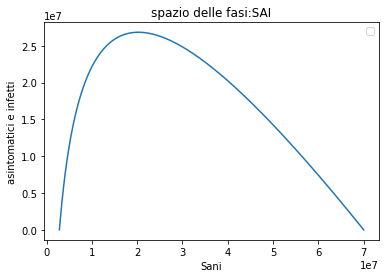

In [3]:
#MODELLO BASE: SANI, ASINTOMATICI, INFETTI, SENZA AZIONI DI CONTENIMENTO

def SAI_model(y,t,beta,epsilon,alpha,k):
	S,A,I =y
	dSdt=-beta*S*I-beta*S*epsilon*A
	dAdt=beta*S*I+beta*S*epsilon*A-k*A
	dIdt=k*A-alpha*I

	return ([dSdt ,dAdt, dIdt])


def SAI(S0,A0,beta):

	I0=0

	t = np.linspace(0,150, 10000)
	epsilon1=0.5  #times beta is the rate of infectivity by being asymptomatic
	alpha1=0.125   #rate at which people leave the class I (by recovering or dying)
	k1=0.3 #rate of passage from A to I
	f1=0.98   #survival rate



	#solve the problem
	solution=odeint(SAI_model, [S0,A0,I0],t, args=(beta,epsilon1,alpha1,k1))
	solution=np.array(solution)



	#R=(S+I+A-N0)(-f)  and N=R(f-1)/f+N0
	recovered=(solution[:,0]+solution[:,1]+solution[:,2]-initial_population)*(-f1)
	N=recovered*(f1-1)/f1+initial_population


	sani_e_immuni=solution[:,0]+recovered
	plt.plot(t,sani_e_immuni, color="green", label="sani e immuni")  #sani e recovered/immuni
	plt.plot(t,solution[:,1], color="orange",label="asintomatici")    #asintomatici
	plt.plot(t,solution[:,2], color="red", label="infetti")     #infetti
	plt.title("senza interventi:SAI")
	plt.legend()
	plt.show()


	plt.plot(solution[:,0],solution[:,1]+solution[:,2])    #sani vs asintomatici e infetti 
	plt.xlabel("Sani")
	plt.ylabel("asintomatici e infetti")
	plt.title("spazio delle fasi:SAI")
	plt.legend()
	plt.show()

	return(solution[:,0],solution[:,1],solution[:,2])



sai=SAI(Sani,Asintomatici,beta_zero)





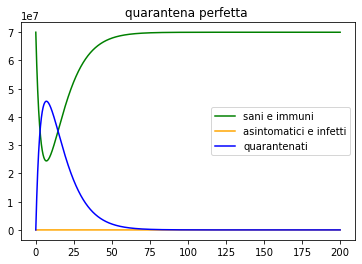

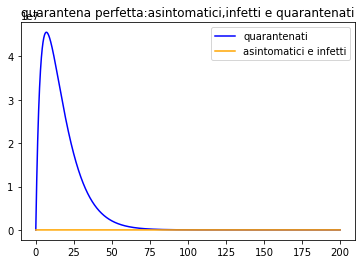

No handles with labels found to put in legend.


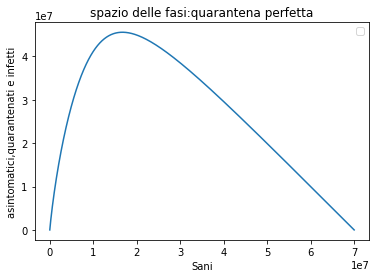

In [4]:


#MODELLO CON UNA QUARANTENA PERFETTA: CHI E QUARANTENATO NON PUO CONTAGIARE NESSUNO

def perfect_quarantene_model(y,t,beta,epsilon,alpha,k,gamma,gamma_i,eta,ro):
	S,A,I,Q_as, Q_i =y
	dSdt=-beta*S*I-beta*S*epsilon*A-gamma*S+eta*Q_as
	dAdt=beta*S*I+beta*S*epsilon*A-k*A-gamma*A
	dIdt=k*A-gamma_i*I-alpha*I
	dQ_asdt=gamma*(A+S)-eta*Q_as-ro*Q_as
	dQ_idt=gamma_i*I+ro*Q_as-alpha*Q_i


	return ([dSdt ,dAdt, dIdt, dQ_asdt, dQ_idt])

def perfect_quarantene(S0,A0,I0,beta,gamma, gamma_i):
	#dato iniziale
	Q_as0=0
	Q_i0=0
	N0=S0+A0

	initial_population=S0+A0+I0

	#parametri
	t = np.linspace(0,200, 10000)
	epsilon1=0.5   #multiplied by beta gives infectivity by being asymptomatic
	alpha1=0.125  #rate at which people leave the class I (by recovering or dying)
	k1=0.3  #rate of passage from A to I

	#gamma1=0.3 #quarantine rate for asymptomatic people
	#gamma_i1=0.7   #quatantene rate for symptomatic people
	eta1=0.1   #rate di ritorno alla classe dei sucettibili dalla quarantena
	ro1=0.15   #rate di passaggio da Q_as in Q_i


	solution_q=odeint(perfect_quarantene_model , [S0,A0,I0,Q_as0,Q_i0],t, args=(beta,epsilon1,alpha1,k1,gamma,gamma_i,eta1,ro1))
	solution_q=np.array(solution_q)
	recovered_q=initial_population-solution_q[:,4]-solution_q[:,3]-solution_q[:,2]-solution_q[:,1]-solution_q[:,0]


	plt.plot(t,solution_q[:,0]+recovered_q, color="green", label="sani e immuni") #S+R
	plt.plot(t,solution_q[:,1]+solution_q[:,2], color="orange", label="asintomatici e infetti") #A+I
	#plt.plot(t,solution_q[:,2], color="red", label="infetti") #I
	plt.plot(t,solution_q[:,3]+solution_q[:,4], color="blue",label="quarantenati") #Q
	plt.title("quarantena perfetta ")
	plt.legend()
	plt.show()


	plt.plot(t,solution_q[:,3]+solution_q[:,4], color="blue",label="quarantenati") #Q
	plt.plot(t,solution_q[:,1]+solution_q[:,2], color="orange", label="asintomatici e infetti") #A+I
	plt.title("quarantena perfetta:asintomatici,infetti e quarantenati")
	plt.legend()
	plt.show()


	plt.plot(solution_q[:,0],solution_q[:,1]+solution_q[:,2]+solution_q[:,3]+solution_q[:,4])    #sani vs asintomatici,quarantenati e infetti 
	plt.xlabel("Sani")
	plt.ylabel("asintomatici,quarantenati e infetti")
	plt.title("spazio delle fasi:quarantena perfetta")
	plt.legend()
	plt.show()



#parametri di quarantena, che possiamo cambiare per osservare grafici diversi

gamma=0.3 #quarantine rate for asymptomatic and healthy people
gamma_i=0.7   #quatantene rate for symptomatic people



siq=perfect_quarantene(Sani,Asintomatici,Infetti,beta_zero, gamma,gamma_i)

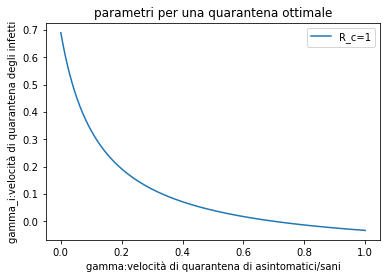

In [8]:
#ma quali parametri di quarantena fanno in modo che la pandemia declini subbito? cioè con quali gamma e gamma_i otteniamo R_c<1?

def parametri_quarantena(beta,N0): 

	#teniamo gli stessi parametri di sopra 
	epsilon1=0.5   #multiplied by beta gives infectivity by being asymptomatic
	alpha1=0.125  #rate at which people leave the class I (by recovering or dying)
	k1=0.3  #rate of passage from A to I
	eta1=0.1   #rate di ritorno alla classe dei sucettibili dalla quarantena
	ro1=0.15    #rate di passaggio da Q_as in Q_i
	

	x=np.linspace(0,1,1000)
	y=(beta*N0*(k1+epsilon1*alpha1)-alpha1*(k1+x))/(k1+x-beta*N0*epsilon1)

	plt.plot(x,y, label="R_c=1")
	plt.xlabel("gamma:velocità di quarantena di asintomatici/sani")	
	plt.ylabel("gamma_i:velocità di quarantena degli infetti")
	plt.title("parametri per una quarantena ottimale")
	plt.legend()
	plt.show()


parametri_ottimali_quarantena_perfetta=parametri_quarantena(beta_zero,initial_population)

#I parametri per cui R_c<1 sono quelli al di sopra della curva R_C=1, e per una quarantena efficente dovremmo cercare di raggiungerli.





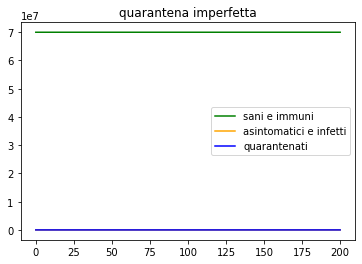

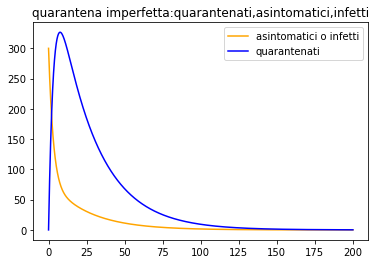

No handles with labels found to put in legend.


(N0,0,0,0,0) è un equilibrio linearmente stabile per il modello di quarantena imperfetta


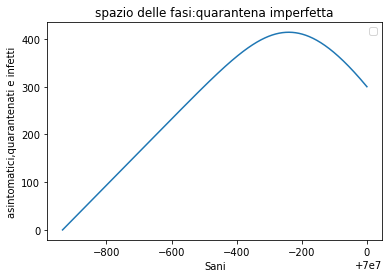

In [17]:
#QUARANTENA IMPERFETTA

#oss: qui quaranteniamo solo le persone infette o asintomatiche

def imperfect_quarantene_model(y,t,beta,epsilon_a,epsilon_q,alpha,k,gamma_a,gamma_i,f):
	S,A,I,Q_a,Q_i,N =y
	dSdt=-beta*S*(I+epsilon_a*A+epsilon_q*epsilon_a*Q_a+epsilon_q*Q_i)
	dAdt=beta*S*(I+epsilon_a*A+epsilon_q*epsilon_a*Q_a+epsilon_q*Q_i)-(k+gamma_a)*A   #divento asintomatico o tramite infetto, o asintomatico, o infetto in quarantena o asintomatico in quarantena
	dIdt=k*A-(gamma_i+alpha)*I   #divento infetto dopo essere stato asintomatico per un po' e poi posso finire in quarantena (gamma) o morire/guarire (alpha)
	dQ_adt=gamma_a*A-k*Q_a  #vengo quarantenato con rate gamma_a, passo in Q_i quando passo da asintomatico ad infetto
	dQ_idt=gamma_i*I+k*Q_a-alpha*Q_i   #quarantenato con rate gamma_i >gamma_a (è più facile finire in quarantena se infetto che asintomatico)
	dNdt=-(1-f)*alpha*(Q_i+I)  #variozione della popolazione, sempre descrescente, togliamo i morti 

	return ([dSdt ,dAdt, dIdt, dQ_adt,dQ_idt, dNdt])

def imperfect_quarantene(S0,A0,I0,beta,gamma_a,gamma_i , linearizzato,tempo):
	#dati iniziali
	Q_a0=0
	Q_i0=0
	N0=S0+A0+I0
	
	#paraneters
	#mean_infective_period=10
	t = np.linspace(0,200, 10000)
	epsilon_a1=0.5   #multiplied by beta gives infectivity by being asymptomatic
	epsilon_q1=0.095 #we muliply infectivity by this parameter to show its decrease by being quarantened
	alpha1=0.125   #rate at which people leave the class I (by recovering or dying)
	k1=0.3  #rate of passage from A to I
	f1=0.99   #survival rate



	solution_q=odeint(imperfect_quarantene_model , [S0,A0,I0,Q_a0,Q_i0, N0],t, args=(beta,epsilon_a1,epsilon_q1,alpha1,k1,gamma_a,gamma_i,f1))
	solution_q=np.array(solution_q)
	recovered_q=solution_q[:,5]-solution_q[:,4]-solution_q[:,3]-solution_q[:,2]-solution_q[:,1]-solution_q[:,0]


	plt.plot(t,solution_q[:,0]+recovered_q, color="green", label="sani e immuni") #S+R
	plt.plot(t,solution_q[:,1]+solution_q[:,2], color="orange", label="asintomatici e infetti") #A+I
	#plt.plot(t,solution_q[:,2], color="red", label="infetti") #I
	plt.plot(t,solution_q[:,3]+solution_q[:,4], color="blue",label="quarantenati") #Q_a+Q_i
	plt.title("quarantena imperfetta")
	plt.legend()
	plt.show()

	plt.plot(t,solution_q[:,1]+solution_q[:,2], color="orange", label="asintomatici o infetti") #A+I
	plt.plot(t,solution_q[:,3]+solution_q[:,4], color="blue",label="quarantenati") #Q_a+Q_i
	plt.title('quarantena imperfetta:quarantenati,asintomatici,infetti')
	plt.legend()
	plt.show()



	#LINEARIZZAZIONE ALL' EQUILIBRIO (S1,0,0,0,0):

	if linearizzato==True:

		S1=N0 #we can change this parameter to see if other equilibriums are stable or not. Here we are looking at the case where all the population is healthy, and we want to see 
	#what happens if we start close to this equilibrium.if the equilibrium is unstable we will have a spread of the disease, while if it is stable it will dye out quiclky. 
	

		m12=-beta*epsilon_a1*S1
		m13=-beta*S1
		m14=-epsilon_a1*epsilon_q1*beta*S1
		m15=-beta*epsilon_q1*S1

		m22=beta*epsilon_a1*S1-gamma_a-k1
		m23=beta*S1
		m24=epsilon_a1*epsilon_q1*beta*S1
		m25=beta*epsilon_q1*S1

		m32=k1
		m33=-alpha1-gamma_i

		m42=gamma_a
		m44=-k1

		m53=gamma_i
		m54=k1
		m55=-alpha1


	#matrice del linearizzato nel punto di equilibrio
		M = np.matrix([[0, m12, m13,m14,m15],
			[0,m22, m23,m24,m25],
			[0,m32,m33,0,0],
			[0,m42,0,m44,0],
			[0,0,m53,m54,m55],
			])
         

		eigenvalues = np.linalg.eigvals(M)
		eigenvalues_real=eigenvalues.real
		#print(eigenvalues_real)

		max_real_eigenvalue=eigenvalues_real.max()
		#min_real_eigenvalue=eigenvalues_real.min()

		#print(np.diag(M)), la matrice è diagonalizzabile

		if max_real_eigenvalue>0:
			print("(N0,0,0,0,0) è un equilibrio instabile per il modello di quarantena imperfetta")  #esiste autovalore con parte reale positiva
		if max_real_eigenvalue<0:
			print("(N0,0,0,0,0) è un equilibrio stabile per il modello di quarantena imperfetta")   #tutti autovalori con parte reale negativa
		else: 
			print("(N0,0,0,0,0) è un equilibrio linearmente stabile per il modello di quarantena imperfetta")   #autovalori con parte reale minore a zero e uguale a zero
	

	plt.plot( solution_q[:,0],solution_q[:,1]+solution_q[:,2]+solution_q[:,3]+solution_q[:,4])    #sani vs asintomatici,quarantenati e infetti 
	plt.xlabel("Sani")
	plt.ylabel("asintomatici,quarantenati e infetti")
	plt.title("spazio delle fasi:quarantena imperfetta")
	plt.legend()
	plt.show()


	#quado arriviamo a zero infetti, asintomatici, quarantenati?
	if tempo==True:
			for i in range(10000):
				if solution_q[i,1]<10 and solution_q[i,2]<15 and solution_q[i,3]<15 and solution_q[i,4]<15:
					Tempo=i*0.02
					print("il tempo per arrivare verso la fine del contagio da quando è iniziata la quarantena con questi parametri è "+str(Tempo)+" giorni")
					break
	



siq_imperfect=imperfect_quarantene(Sani,Asintomatici,Infetti, beta_zero,gamma, gamma_i, True, False)
 



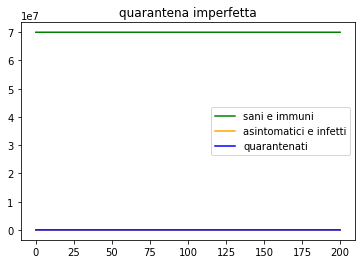

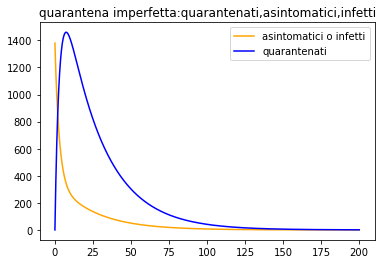

No handles with labels found to put in legend.


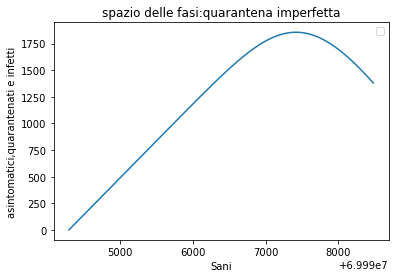

il tempo per arrivare verso la fine del contagio da quando è iniziata la quarantena con questi parametri è 121.56 giorni


In [19]:

#MODELLO IN CUI ALL'INIZIO ABBIAMO SAI(modello senza interventi di quarantena) SEGUITO DALLA QUARANTENA CHE PARTE DAL GIORNO 10
S=sai[0]  #dati sulle persone sane nel tempo
S0=S[670]
A=sai[1]   #dati su asintomatici nel tempo
A0=A[670]
#print(A0)
I=sai[2]   
I0=I[670]
#print(I0)

quarantena_dopo_dieci_giorni=imperfect_quarantene(S0,A0,I0,beta_zero,gamma, gamma_i, False, True)





















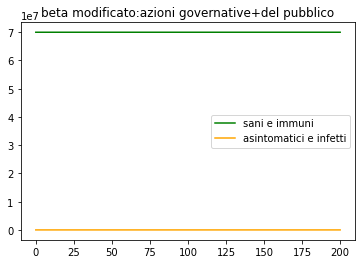

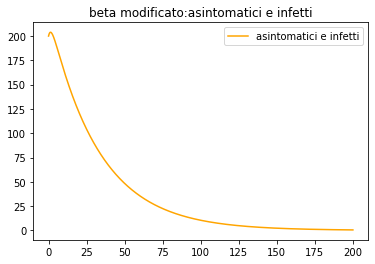

In [18]:
#MODELLO IN CUI MODIFICHIAMO IL PARAMETRO BETA PER TENERE CONTO DI AZIONI GOVERNATIVE E REAZIONE DEL PUBBLICO

g1=0.75   #azione governativa
D1=0.4   #percezione di rischio del pubblico, in reazione alle morti
p1=1117   #potenza della reazione
c1=0.2 #proporzione di casi critici
r1=0.08  #inverso del tempo medio di reazione pubblica 
#parametri presi da https://www.ijidonline.com/action/showPdf?pii=S1201-9712%2820%2930117-X 

def SAI_beta_model(y,t,beta_zero,epsilon,alpha,k,f,g,D,p,c,r):
	
	S,A,I,D,N =y
	dSdt=-beta_zero*((1-g)*(1-D/N)**p)*S*(I+epsilon*A)
	dAdt=beta_zero*((1-g)*(1-D/N)**p)*S*(I+epsilon*A)-k*A
	dIdt=k*A-alpha*I
	dDdt=c*alpha*I-r*D
	dNdt=-(1-f)*alpha*I



	return ([dSdt ,dAdt, dIdt,dDdt, dNdt])



def SAI_beta(S0,A0,beta_zero,g,D,p,c,r):

	I0=0
	N0=S0+A0
	D0=0

	t = np.linspace(0,200, 10000)
	epsilon1=0.4   #decrease of infectivity by being asymptomatic
	alpha1=0.13  #rate at which people leave the class I (by recovering or dying)
	k1=0.5 #rate of passage from A to I
	f1=0.99   #survival rate


	#solve the problem
	solution=odeint(SAI_beta_model, [S0,A0,I0,D0,N0],t, args=(beta_zero,epsilon1,alpha1,k1,f1,g,D,p,c,r))
	solution=np.array(solution)


	recovered=solution[:,4]-solution[:,2]-solution[:,1]-solution[:,0]



	sani_e_immuni=solution[:,0]+recovered
	plt.plot(t,sani_e_immuni, color="green", label="sani e immuni")  #sani e recovered/immuni
	plt.plot(t,solution[:,1]+solution[:,2], color="orange",label="asintomatici e infetti")    #asintomatici e infetti
	plt.title("beta modificato:azioni governative+del pubblico")
	plt.legend()
	plt.show()



	plt.plot(t,solution[:,1]+solution[:,2], color="orange",label="asintomatici e infetti")    #asintomatici e infetti
	plt.title("beta modificato:asintomatici e infetti")
	plt.legend()
	plt.show()


beta_modificato=SAI_beta(Sani,Asintomatici,beta_zero,g1,D1,p1,c1,r1)
